In [1]:
#Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from tempfile import TemporaryDirectory

In [2]:
compose_transform = transforms.Compose([
    transforms.Resize((232,232)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor()])
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) #Resnet uses these values

In [3]:
train_dataset = datasets.ImageFolder('hymenoptera_data/train', transform = compose_transform)
train_dataload = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
train_dataiter = iter(train_dataload)

test_dataset = datasets.ImageFolder('hymenoptera_data/val', transform = compose_transform)
test_dataload = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = True)
test_dataiter = iter(test_dataload)

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
len(train_dataset)

244

In [4]:
classes = train_dataset.classes

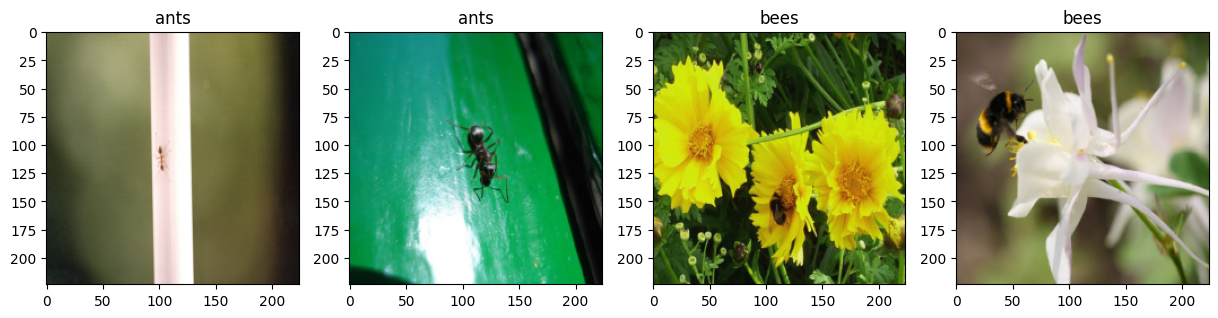

In [5]:
images, label = next(train_dataiter)
fig, ax = plt.subplots(ncols = 4, figsize = (15,15))
for i in range(4):
    ax[i].imshow(images[i].permute(1, 2, 0))
    ax[i].title.set_text(train_dataset.classes[label[i]])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epoch = 25):
    since = time.time()

    #Create a temporary directory to save training checkpoint
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epoch):
            print('Epoch {}/{}'.format(epoch + 1, num_epoch))
            print('-' * 10)

            #Each epoch has a training and validation phase
            for phase in ['train','val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0.0

                #Iterate over datas
                if phase == 'train':
                    for images, labels in train_dataload:
                        optimizer.zero_grad()
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(images)
                            val, idx = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()

                        running_loss += loss.item() * images.size(0)
                        running_corrects += torch.sum(idx == labels.data)
                    scheduler.step()
                    epoch_loss = running_loss /  len(train_dataset)
                    epoch_acc = running_corrects.double() / len(train_dataset)
                    print('Train Loss: {} \tTrain Accuracy: {}'.format(epoch_loss, epoch_acc))

                else:
                    for images, labels in test_dataload:
                        optimizer.zero_grad()
                        outputs = model(images)
                        val, idx = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        running_loss += loss.item() * images.size(0)
                        running_corrects += torch.sum(idx == labels.data)
                        
                    epoch_loss = running_loss / len(test_dataset)
                    epoch_acc = running_corrects.double() / len(test_dataset)
                    print('Test Loss: {} \t\tTest Accuracy: {}'.format(epoch_loss, epoch_acc))

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            print('\n\n')
        time_elapsed = time.time() - since
        print('Training completed in {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best Validation Accuracy'.format(best_acc))
        
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [8]:
model_finetune = models.resnet18(weights = 'IMAGENET1K_V1')
num_ftrs = model_finetune.fc.in_features

model_finetune.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_finetune.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [9]:
model_ft = train_model(model_finetune, criterion, optimizer_ft, exp_lr_scheduler, num_epoch = 25)

Epoch 1/25
----------
Train Loss: 0.5260920497726221 		Train Accuracy: 0.7540983606557377
Test Loss: 0.354112053846384 		Test Accuracy: 0.8636363636363636



Epoch 2/25
----------
Train Loss: 0.24876302676122697 		Train Accuracy: 0.9180327868852459
Test Loss: 0.21603463919131788 		Test Accuracy: 0.9415584415584416



Epoch 3/25
----------
Train Loss: 0.13305604531139623 		Train Accuracy: 0.9631147540983607
Test Loss: 0.198277438035259 		Test Accuracy: 0.922077922077922



Epoch 4/25
----------
Train Loss: 0.1240991873086476 		Train Accuracy: 0.9508196721311475
Test Loss: 0.1755976505674325 		Test Accuracy: 0.9415584415584416



Epoch 5/25
----------
Train Loss: 0.04986514734318022 		Train Accuracy: 0.9918032786885246
Test Loss: 0.249091787384702 		Test Accuracy: 0.8961038961038961



Epoch 6/25
----------
Train Loss: 0.020910257259841827 		Train Accuracy: 0.9959016393442623
Test Loss: 0.1747118408803816 		Test Accuracy: 0.9545454545454546



Epoch 7/25
----------
Train Loss: 0.02412723

In [14]:
torch.save(model_ft.state_dict(), 'Resnet18 Finetune.pt')

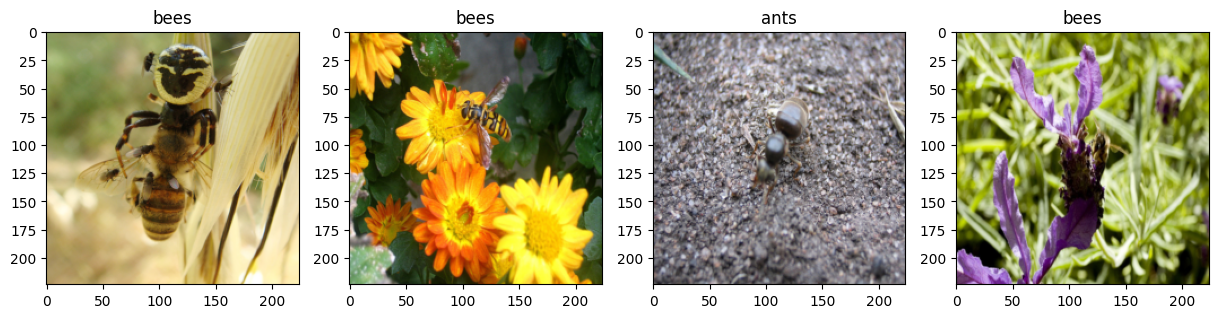

In [29]:
images, label = next(test_dataiter)
outputs = model_ft(images)
fig, ax = plt.subplots(ncols = 4, figsize = (15,15))
for i in range(4):
    ax[i].imshow(images[i].permute(1, 2, 0))
    idx = torch.argmax(outputs[i]).item()
    ax[i].title.set_text(classes[idx])